Traffic Vehicle Real Time Detection - ML Notebook 2 of 2

By: Chris Heimbuch

Dataset: https://datasetninja.com/vehicle-dataset-for-yolo

Overview

In the last notebook, we explored an EDA on all of the images in the dataset to understand the qualities of the image data. I had to organize the images by class via reading each JSON annotation file associated with the images, creating new directories for each class, and moving each file to their respective folder. From there, I was able to perform an organized EDA on the images. I explored the image aspect ratios, the width and height distributions of the dataset, the RGB channel intensity, and class distribution count of all images.

This notebook I will focus on a machine learning approach and neural network approach for my image data, where I will train the models to identify images based on their class. Once that is completed, I will make use of a YOLO model and work to deploy the model online by feeding the model an image, and having it identify the objects in the image in real time, with the objects being type of vehicle.



In [1]:
#Importing in libraries to work with the image data.
import os
import shutil
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image as Image
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#Classic ML
from skimage.feature import hog
from skimage import color, exposure
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, explained_variance_score, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

# Machine Learning Algorithms
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score

# TensorFlow and deep learning libraries
import tensorflow as tf
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")


## Section 1: Machine Learning Approach

In [2]:
#set class specific output paths
annotations_path = r"C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_5\p5_capstone_project\train\ann"
images_path = r"C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_5\p5_capstone_project\train\img"
bus_path = r"C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_5\p5_capstone_project\train\buses"
cars_path = r"C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_5\p5_capstone_project\train\cars"
motorcycles_path = r"C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_5\p5_capstone_project\train\motorcycles"
threewheels_path = r"C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_5\p5_capstone_project\train\threewheels"
trucks_path = r"C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_5\p5_capstone_project\train\trucks"
vans_path = r"C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_5\p5_capstone_project\train\vans"
multiclass_path = r"C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_5\p5_capstone_project\train\multiclass"

#Creating a dictionary for each path for easy access.
class_directories = {
    'bus': bus_path,
    'car': cars_path,
    'motorcycles': motorcycles_path,
    'threewheel': threewheels_path,
    'truck': trucks_path,
    'van': vans_path,
    'multiclass': multiclass_path
}

In [5]:
#Here I am extracting out the images from my combined folder, and adding them to the "image" variable. 
#By default, cv2 stores image in BGR format, in which to display some images, I will need to convert them to RGB.

# image_list = os.listdir(input_dir_train)
# folders = ['Directional_Signs', 'Speed_Limit', 'Warning_Signs']

image = []
class_name = []

#go through the folders and classes in dictionary
for object_name, folder_path in class_directories.items():

    #list of images in newly created folders
    pictures = os.listdir(folder_path)

    for img in pictures:
        img_path = os.path.join(folder_path, img)
        current = cv2.imread(img_path)
        #Convert to RGB for plotting for matplotlib
        current_rgb = cv2.cvtColor(current, cv2.COLOR_BGR2RGB)

        image.append(current_rgb)
        class_name.append(object_name)

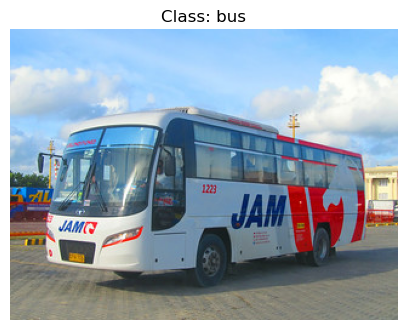

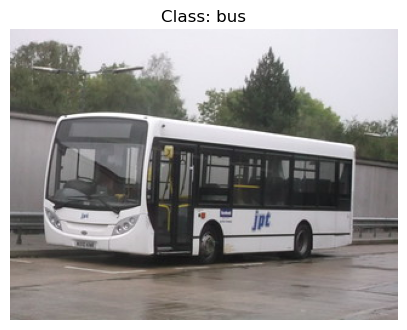

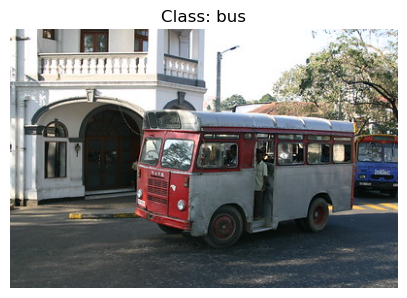

In [12]:
#Inspect a few images in the image list

# Display one image from each folder
for i in range(3): 
    plt.figure(figsize=(5, 5))
    plt.imshow(image[i])
    plt.title(f"Class: {class_name[i]}")
    plt.axis('off')
    plt.show()

In [14]:
#Going to prepare image data to work with. I will first handle the training data.

image_data = []
labels = []
class_directories = {
    'bus': bus_path,
    'car': cars_path,
    'motorcycles': motorcycles_path,
    'threewheel': threewheels_path,
    'truck': trucks_path,
    'van': vans_path,
    'multiclass': multiclass_path
}

class_label_mapping = {
    'bus': 0,
    'car': 1,
    'motorcycles': 2,
    'threewheel': 3,
    'truck': 4,
    'van': 5,
    'multiclass': 6
}

#go through the folders and classes in dictionary
for object_name, folder_path in class_directories.items():

        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)

            #read the image in color.
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)

            #this will only proceed if the image exists
            if img is not None:
                #resize image to fixed size so its uniform ( as most images had different heights and widths)
                img_resized = cv2.resize(img, (128,128))

                #make image interpretable for machine models by flattening it into a 1D array.
                img_flattened = img_resized.flatten()

                #add the flattened image and the label to the lists above that we instantiated.
                image_data.append(img_flattened)
                labels.append(class_label_mapping[object_name])
            else:
                print(f"The image could not be read {image_path}")

#convert the lists into numpy arrays for efficiency
image_data = np.array(image_data)
labels = np.array(labels)

In [16]:
labels

array([0, 0, 0, ..., 6, 6, 6])

In [17]:
#Convert image data to a DataFrame
df = pd.DataFrame(image_data)

#Scale data so it is more managable for machine models.
df = df / 255

# Add the labels as the target column
df['label'] = labels

df

,0,1,2,3,4,5,6,7,8,9,...,49143,49144,49145,49146,49147,49148,49149,49150,49151,label
0,0.996078,0.768627,0.545098,0.996078,0.772549,0.549020,0.996078,0.776471,0.552941,1.000000,...,0.498039,0.537255,0.517647,0.450980,0.490196,0.466667,0.482353,0.509804,0.486275,0
1,0.901961,0.866667,0.878431,0.905882,0.870588,0.882353,0.905882,0.870588,0.882353,0.913725,...,0.513725,0.521569,0.560784,0.509804,0.517647,0.556863,0.517647,0.525490,0.564706,0
2,1.000000,0.992157,1.000000,0.972549,0.992157,0.992157,0.549020,0.541176,0.517647,0.737255,...,0.443137,0.439216,0.435294,0.462745,0.466667,0.458824,0.360784,0.360784,0.360784,0
3,0.376471,0.501961,0.419608,0.415686,0.501961,0.447059,0.505882,0.549020,0.498039,0.478431,...,0.560784,0.549020,0.517647,0.552941,0.541176,0.509804,0.556863,0.545098,0.513725,0
4,0.211765,0.172549,0.400000,0.396078,0.352941,0.529412,0.333333,0.286275,0.423529,0.290196,...,0.031373,0.023529,0.019608,0.031373,0.027451,0.015686,0.035294,0.027451,0.011765,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,0.098039,0.117647,0.129412,0.117647,0.094118,0.098039,0.066667,0.062745,0.098039,0.062745,...,0.580392,0.545098,0.529412,0.560784,0.560784,0.537255,0.635294,0.619608,0.600000,6
2096,0.164706,0.345098,0.341176,0.713725,0.701961,0.662745,0.917647,0.874510,0.819608,0.772549,...,0.223529,0.278431,0.309804,0.447059,0.494118,0.529412,0.317647,0.380392,0.423529,6
2097,0.023529,0.298039,0.235294,0.211765,0.443137,0.400000,0.290196,0.462745,0.431373,0.949020,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6
2098,0.929412,0.894118,0.854902,0.929412,0.894118,0.854902,0.929412,0.894118,0.854902,0.929412,...,0.643137,0.694118,0.749020,0.654902,0.713725,0.749020,0.627451,0.686275,0.721569,6


In [18]:
#Going to create a function for "Shotgun approach" for machine learning modeling.

def classification_model_test(model, X_train, y_train, X_test, y_test):
    # Fit the model with the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate and return the accuracy score
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

    # Generate heatmap of confusion matrix
    sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred),
            annot=True,
            cmap="coolwarm",
            square=True)

    # Print classification report
    print(classification_report(y_true=y_test, y_pred=y_pred))

    return f"Accuracy Score: {accuracy:.2f}"

In [19]:
X = df.drop(columns=['label'])
y = df['label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

              precision    recall  f1-score   support

           0       0.44      0.46      0.45        68
           1       0.45      0.32      0.37        78
           2       0.27      0.32      0.30        56
           3       0.31      0.33      0.32        54
           4       0.38      0.34      0.36        83
           5       0.29      0.40      0.34        58
           6       0.00      0.00      0.00        23

    accuracy                           0.34       420
   macro avg       0.31      0.31      0.31       420
weighted avg       0.35      0.34      0.34       420



'Accuracy Score: 0.34'

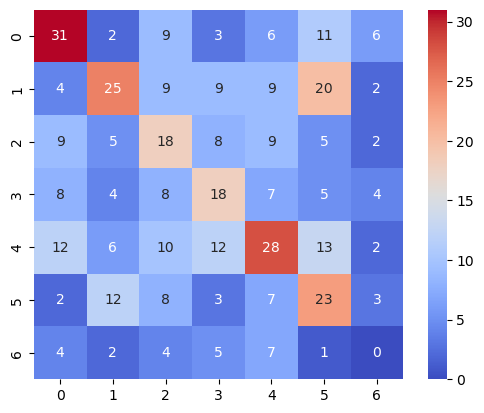

In [20]:
log_reg = LogisticRegression()
classification_model_test(log_reg, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.45      0.46      0.45        68
           1       0.51      0.33      0.40        78
           2       0.34      0.36      0.35        56
           3       0.35      0.41      0.38        54
           4       0.39      0.33      0.36        83
           5       0.30      0.50      0.37        58
           6       0.00      0.00      0.00        23

    accuracy                           0.37       420
   macro avg       0.33      0.34      0.33       420
weighted avg       0.38      0.37      0.37       420



'Accuracy Score: 0.37'

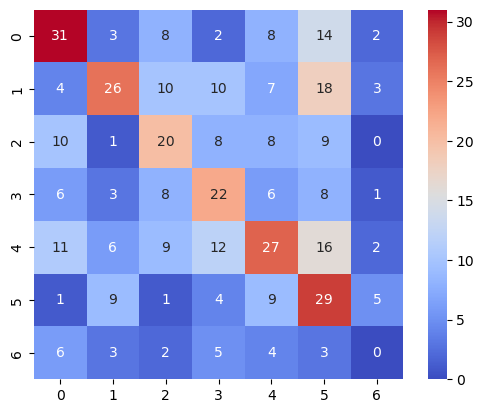

In [21]:
sgd_model = SGDClassifier()
classification_model_test(sgd_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.49      0.62      0.55        68
           1       0.46      0.51      0.48        78
           2       0.29      0.43      0.35        56
           3       0.44      0.39      0.41        54
           4       0.48      0.37      0.42        83
           5       0.49      0.43      0.46        58
           6       0.00      0.00      0.00        23

    accuracy                           0.44       420
   macro avg       0.38      0.39      0.38       420
weighted avg       0.42      0.44      0.42       420



'Accuracy Score: 0.44'

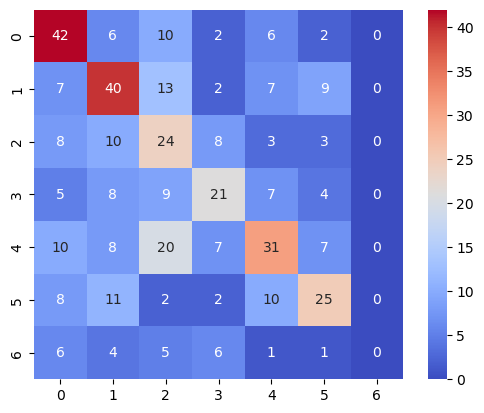

In [22]:
svc_model = SVC()
classification_model_test(svc_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.46      0.60      0.52        68
           1       0.40      0.44      0.42        78
           2       0.39      0.50      0.44        56
           3       0.47      0.48      0.48        54
           4       0.53      0.37      0.44        83
           5       0.49      0.52      0.50        58
           6       0.00      0.00      0.00        23

    accuracy                           0.45       420
   macro avg       0.39      0.42      0.40       420
weighted avg       0.43      0.45      0.44       420



'Accuracy Score: 0.45'

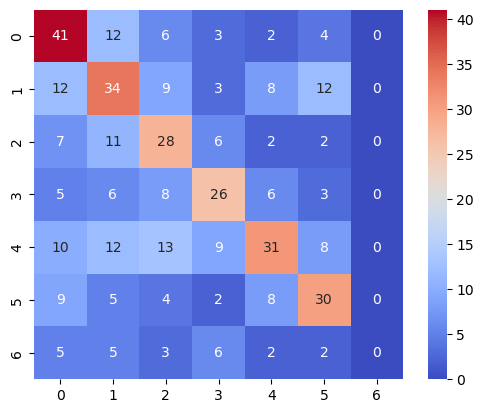

In [23]:
rfc_model = RandomForestClassifier()
classification_model_test(rfc_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.50      0.59      0.54        68
           1       0.46      0.51      0.48        78
           2       0.37      0.41      0.39        56
           3       0.41      0.46      0.43        54
           4       0.51      0.41      0.45        83
           5       0.43      0.45      0.44        58
           6       0.00      0.00      0.00        23

    accuracy                           0.45       420
   macro avg       0.38      0.40      0.39       420
weighted avg       0.43      0.45      0.44       420



'Accuracy Score: 0.45'

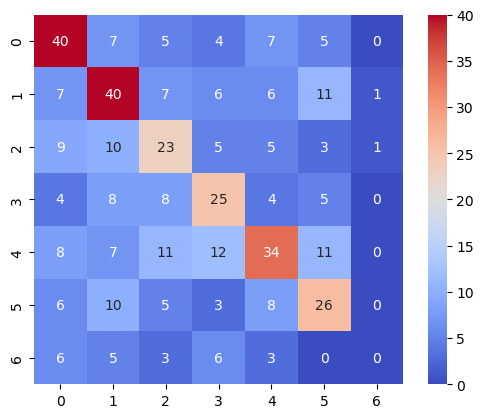

In [24]:
gbc_model = GradientBoostingClassifier()
classification_model_test(gbc_model, X_train, y_train, X_test, y_test)

After this shotgun approach on basic machine learning classifiers, it is clear that this data is very nuanced and basic ML classifiers are having trouble picking up on complex patterns within the image data. Therefore, I will employ a CNN model and train it to learn about the complex heuristics of the images.

## Section 2: Deep Learning

In this section I will construct a custom CNN network and train it on my image data. I will construct a sequential model.

In [3]:
#Instancing a Sequential model
Sequential = tf.keras.models.Sequential

#CNN Network Layers
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout
Flatten = tf.keras.layers.Flatten
Conv2D = tf.keras.layers.Conv2D
MaxPool2D = tf.keras.layers.MaxPool2D

#Optimizer
Adam = tf.keras.optimizers.Adam

#Image Preprocessing
ImageDataGenerator =  tf.keras.preprocessing.image.ImageDataGenerator

In [4]:
#Going to prepare image data to work with. I will first handle the training data.

cnn_image_data = []
cnn_labels = []
class_directories = {
    'bus': bus_path,
    'car': cars_path,
    'motorcycles': motorcycles_path,
    'threewheel': threewheels_path,
    'truck': trucks_path,
    'van': vans_path,
    'multiclass': multiclass_path
}

class_label_mapping = {
    'bus': 0,
    'car': 1,
    'motorcycles': 2,
    'threewheel': 3,
    'truck': 4,
    'van': 5,
    'multiclass': 6
}

#go through the folders and classes in dictionary
for object_name, folder_path in class_directories.items():

        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)

            #read the image in color.
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)

            #this will only proceed if the image exists
            if img is not None:
                #resize image to fixed size so its uniform ( as most images had different heights and widths)
                img_resized = cv2.resize(img, (300,300))

                #add the flattened image and the label to the lists above that we instantiated.
                cnn_image_data.append(img_resized)
                cnn_labels.append(class_label_mapping[object_name])
            else:
                print(f"The image could not be read {image_path}")

#convert the lists into numpy arrays for efficiency
cnn_image_data = np.array(cnn_image_data)
cnn_labels = np.array(cnn_labels)

In [5]:
#I am going to scale the image data to 0-1 range for the model.

cnn_image_data = cnn_image_data / 255.0

cnn_image_data

array([[[[1.        , 0.76862745, 0.54901961],
         [1.        , 0.76862745, 0.54901961],
         [1.        , 0.76862745, 0.54901961],
         ...,
         [0.99607843, 0.78039216, 0.5254902 ],
         [0.99607843, 0.77647059, 0.52156863],
         [0.99607843, 0.77647059, 0.52156863]],

        [[0.99607843, 0.76862745, 0.54117647],
         [0.99607843, 0.76862745, 0.54117647],
         [1.        , 0.77254902, 0.54509804],
         ...,
         [1.        , 0.77647059, 0.52941176],
         [1.        , 0.77647059, 0.52941176],
         [0.99607843, 0.77254902, 0.5254902 ]],

        [[0.99607843, 0.76862745, 0.5372549 ],
         [0.99607843, 0.76862745, 0.5372549 ],
         [1.        , 0.77254902, 0.54117647],
         ...,
         [1.        , 0.78039216, 0.5372549 ],
         [1.        , 0.78039216, 0.5372549 ],
         [1.        , 0.77647059, 0.53333333]],

        ...,

        [[0.49411765, 0.58431373, 0.58823529],
         [0.49411765, 0.58039216, 0.58431373]

In [6]:
# # Split the data into training and test sets
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(cnn_image_data, cnn_labels, train_size=0.8, test_size=0.2, random_state=42)

# Image Type Forcing
X_train_cnn = X_train_cnn.astype("float32"); X_test_cnn = X_test_cnn.astype("float32")

In [7]:
#One-hot encode the labels
y_train_cnn = to_categorical(y_train_cnn, num_classes=7)
y_test_cnn = to_categorical(y_test_cnn, num_classes=7)

In [8]:
# Here I will define the network layers.
convolutional_layer_1 = Conv2D(50,
                               kernel_size=(3, 3),
                               strides=(1, 1),
                               padding="same",
                               activation="relu",
                               input_shape=(300, 300, 3))
convolutional_layer_2 = Conv2D(75,
                               kernel_size=(3, 3),
                               strides=(1, 1),
                               padding="same",
                               activation="relu")
convolutional_layer_3 = Conv2D(125,
                               kernel_size=(3, 3),
                               strides=(1, 1),
                               padding="same",
                               activation="relu")

# Two corresponding pooling layers to reduce convolved dimensionality
pooling_layer_1 =         MaxPool2D(pool_size=(2, 2))
pooling_layer_2 =         MaxPool2D(pool_size=(2, 2))

# Four dropout layers: two for the convolutions and two for the ANN
dropout_layer_1 =         Dropout(0.25)
dropout_layer_2 =         Dropout(0.25)
dropout_layer_3 =         Dropout(0.4)
dropout_layer_4 =         Dropout(0.3)

# A flattening layer for ingestion into the ANN
flattening_layer_1 =      Flatten()

# Three dense layers to make up the significant ANN architecture
connective_layer_1 =      Dense(500, activation="relu")
connective_layer_2 =      Dense(250, activation="relu")
output_layer =            Dense(7, activation="softmax")

In [9]:
# Initialize sequential model schema
model = Sequential()

# Add first convolutional feature mapping process layers
model.add(convolutional_layer_1)

# Add second convolutional feature mapping process layers
model.add(convolutional_layer_2)
model.add(pooling_layer_1)
model.add(dropout_layer_1)

# Add third convolutional feature mapping process layers
model.add(convolutional_layer_3)
model.add(pooling_layer_2)
model.add(dropout_layer_2)

# Add image vectorization process layer
model.add(flattening_layer_1)

# Add connective ANN process layers
model.add(connective_layer_1)
model.add(dropout_layer_3)
model.add(connective_layer_2)
model.add(dropout_layer_4)
model.add(output_layer)

# Summarize model layering setup
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 50)      1400      
                                                                 
 conv2d_1 (Conv2D)           (None, 300, 300, 75)      33825     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 75)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 150, 150, 75)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 150, 150, 125)     84500     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 125)      0         
 2D)                                                    

In [10]:
# Define Adam optimization
optimizer = Adam(learning_rate=0.001)

In [11]:
# Set compilation properties
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Set epochs and batch size
epochs, batch_size = 40, 128

In [12]:
# Create image augmentation engine as generator-like object
generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
)

# Fit training data to augmentation generator
generator.fit(X_train_cnn)

In [13]:
#created this only if necessary to use. Doesn't seem like I will need this.

#Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          #this is the number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Rstores the model weights from the best epoch with the lowest validation loss
)

#Define ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(
    filepath='best_model_traffic_images.h5',  #path where model is saved
    monitor='val_loss',        
    save_best_only=True,       
    verbose=1                  
)

In [14]:
print("Independent training set size:\t\t{}".format(X_train_cnn.shape))
print("Independent validation set size:\t{}".format(X_test_cnn.shape))
print("Target training set size:\t\t{}".format(y_train_cnn.shape))
print("Target validation set size:\t\t{}".format(y_test_cnn.shape))

Independent training set size:		(1680, 300, 300, 3)
Independent validation set size:	(420, 300, 300, 3)
Target training set size:		(1680, 7)
Target validation set size:		(420, 7)


In [ ]:
# Fit model using generator-augmented dataset and mini-batch ingestion
history = model.fit(
    generator.flow(X_train_cnn,
                   y_train_cnn,
                   batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_test_cnn, y_test_cnn),
    batch_size=batch_size,
    #callbacks=[early_stopping, model_checkpoint] #This is only if the model is not learning and if something crashes, there will be a save state of performance.
)